Using device: cuda
Epoch 0: Loss = 11.063775
Epoch 200: Loss = 0.013149
Epoch 400: Loss = 0.001060
Epoch 600: Loss = 0.000727
Epoch 800: Loss = 0.001306
Epoch 1000: Loss = 0.000625
Epoch 1200: Loss = 0.000500
Epoch 1400: Loss = 0.000646
Epoch 1600: Loss = 0.000472
Epoch 1800: Loss = 0.000458
Epoch 2000: Loss = 0.000817
Epoch 2200: Loss = 0.000453
Epoch 2400: Loss = 0.018518
Epoch 2600: Loss = 0.000432
Epoch 2800: Loss = 0.000469
Epoch 3000: Loss = 0.002479
Epoch 3200: Loss = 0.000620
Epoch 3400: Loss = 0.001426
Epoch 3600: Loss = 0.000450
Epoch 3800: Loss = 0.000417
Epoch 4000: Loss = 0.000625
Epoch 4200: Loss = 0.000426
Epoch 4400: Loss = 0.000501
Epoch 4600: Loss = 0.000414
Epoch 4800: Loss = 0.000413
Epoch 5000: Loss = 0.000414
Epoch 5200: Loss = 0.000445
Epoch 5400: Loss = 0.000412
Epoch 5600: Loss = 0.000412
Epoch 5800: Loss = 0.000537
Epoch 6000: Loss = 0.000409
Epoch 6200: Loss = 0.000548
Epoch 6400: Loss = 0.000408
Epoch 6600: Loss = 0.000499
Epoch 6800: Loss = 0.000470
Epoch 7

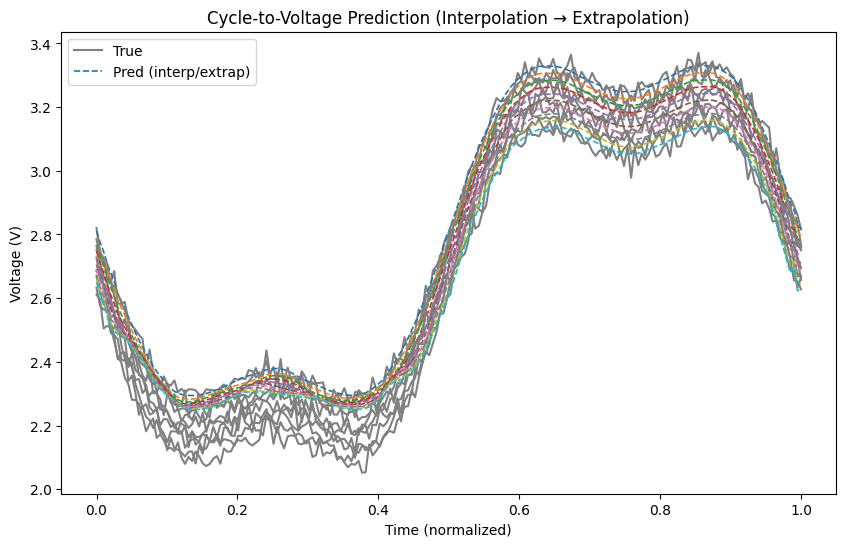

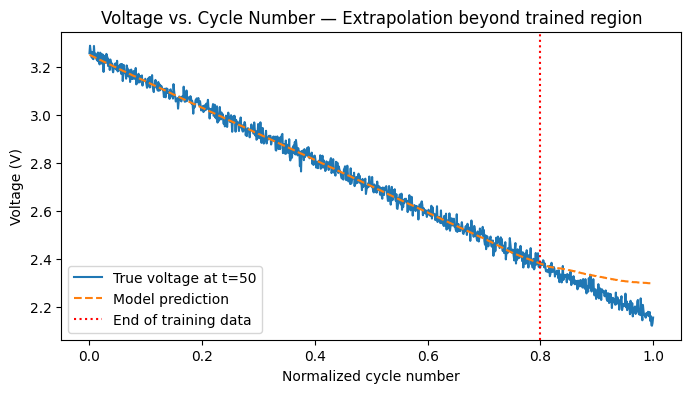

In [6]:
# ========================================
# ⚡ Current → Voltage Neural Net (Interpolation & Extrapolation) — CUDA Version
# ========================================
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# -------------------------------
# 0️⃣ Device setup (GPU or CPU)
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(0)

# --- 1️⃣ Generate synthetic data ---
n_cycles = 800          # training cycles (0–0.8 normalized)
n_test_cycles = 1000    # total (includes extrapolation)
seq_len = 200           # samples per cycle

# Generate synthetic "current" waveforms
t = torch.linspace(0, 1, seq_len, device=device)
base_current = torch.sin(2 * torch.pi * t) * 2 + 0.5 * torch.sin(6 * torch.pi * t)

def generate_voltage(i_t, cycle):
    """Synthetic voltage model: degrades over cycles."""
    decay = 1 - 0.3 * cycle
    ir_drop = 0.1 * (1 + 0.5 * cycle)
    noise = 0.02 * torch.randn_like(i_t)
    return decay * (3.7 - 0.2 * i_t) - ir_drop * i_t + noise

# Generate dataset
cycles = torch.linspace(0, 1, n_test_cycles, device=device)
currents = base_current.repeat(n_test_cycles, 1)
voltages = torch.stack([generate_voltage(currents[i], cycles[i]) for i in range(n_test_cycles)])

# Split train/test
train_idx = torch.arange(0, int(0.8 * n_test_cycles), device=device)
test_idx = torch.arange(int(0.8 * n_test_cycles), n_test_cycles, device=device)
curr_train, volt_train, cyc_train = currents[train_idx], voltages[train_idx], cycles[train_idx]
curr_test, volt_test, cyc_test = currents[test_idx], voltages[test_idx], cycles[test_idx]

# --- 2️⃣ Define model ---
class CurrentToVoltageNet(nn.Module):
    def __init__(self, in_channels=2, hidden_channels=64, n_layers=4):
        super().__init__()
        layers = []
        ch = in_channels
        for _ in range(n_layers):
            layers += [nn.Conv1d(ch, hidden_channels, 5, padding=2), nn.ReLU()]
            ch = hidden_channels
        self.conv = nn.Sequential(*layers)
        self.out = nn.Conv1d(hidden_channels, 1, 1)

    def forward(self, x):
        return self.out(self.conv(x))

model = CurrentToVoltageNet().to(device)  # ✅ send model to GPU
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# --- 3️⃣ Training ---
n_epochs = 50000
for epoch in range(n_epochs):
    cycle_scaled = cyc_train.unsqueeze(1).unsqueeze(2).expand(-1, seq_len, 1)
    inp = torch.cat([curr_train.unsqueeze(2), cycle_scaled], dim=2).permute(0, 2, 1)
    y_true = volt_train.unsqueeze(1)

    # ✅ Ensure tensors are on GPU
    inp, y_true = inp.to(device), y_true.to(device)

    opt.zero_grad()
    pred = model(inp)
    loss = loss_fn(pred, y_true)
    loss.backward()
    opt.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# --- 4️⃣ Evaluate across interpolation & extrapolation ---
preds = []
with torch.no_grad():
    for i in range(len(cyc_test)):
        cnum = cyc_test[i].item()
        inp = torch.cat([
            curr_test[i].unsqueeze(1),
            torch.full_like(curr_test[i].unsqueeze(1), cnum)
        ], dim=1).permute(1, 0).unsqueeze(0).to(device)
        preds.append(model(inp).squeeze().detach().cpu())  # move back to CPU for plotting
preds = torch.stack(preds)

# --- 5️⃣ Visualization ---
fig, ax = plt.subplots(figsize=(10, 6))
for i, cyc in enumerate(cyc_test[::20].cpu()):
    ax.plot(t.cpu(), volt_test[::20][i].cpu(), color='gray', lw=1.5, label='True' if i == 0 else "")
    ax.plot(t.cpu(), preds[::20][i], '--', lw=1.2, label='Pred (interp/extrap)' if i == 0 else "")

ax.set_title("Cycle-to-Voltage Prediction (Interpolation → Extrapolation)")
ax.set_xlabel("Time (normalized)")
ax.set_ylabel("Voltage (V)")
ax.legend()
plt.show()

# --- 6️⃣ Visualize trend at a single point in time ---
time_index = 50  # pick one time sample
true_vs_cycle = voltages[:, time_index].cpu()
pred_vs_cycle = []
with torch.no_grad():
    for cnum in cycles:
        inp = torch.cat([
            base_current.unsqueeze(1),
            torch.full_like(base_current.unsqueeze(1), cnum)
        ], dim=1).permute(1, 0).unsqueeze(0).to(device)
        pred_vs_cycle.append(model(inp).squeeze()[time_index].item())

plt.figure(figsize=(8, 4))
plt.plot(cycles.cpu(), true_vs_cycle, label="True voltage at t=50")
plt.plot(cycles.cpu(), pred_vs_cycle, '--', label="Model prediction")
plt.axvline(0.8, color='r', linestyle=':', label="End of training data")
plt.title("Voltage vs. Cycle Number — Extrapolation beyond trained region")
plt.xlabel("Normalized cycle number")
plt.ylabel("Voltage (V)")
plt.legend()
plt.show()
